## Tutorial4: Using SpatialMOSI for Mosaic Integration on Omics-unpaired Data

## PartI: Integration

### 1. Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import SpatialMOSI

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

[1] "已设置北大阿里云镜像"


### 2. Load Data and Preprocess

In [2]:
from SpatialMOSI.utils import load_data
batch_list1, batch_list2,adj_list, csl_list = load_data(path='./Data/Dataset7_Mouse_Brain_ATAC', slice_ids=['H3K27ac','H3K4me3'],omics_HVGs=[3000,5000], omics=['RNA','CHR'],n_lsi=101, radius=2,chr_hvgs = False,)

graph includs edges: 119900 average edges per node: 12.796
Negative spots selection completed!
graph includs edges: 122188 average edges per node: 12.797
Negative spots selection completed!


In [4]:
from SpatialMOSI.utils import concat
adata_concat_adt=concat(batch_list2,adj_list,csl_list,slice_ids=['H3K27ac_ATAC','H3K4me3_ATAC'])
adata_concat_rna=concat(batch_list1,adj_list,csl_list,slice_ids=['H3K27ac_RNA','H3K4me3_RNA'])

concat matrix shape: (18918, 0)
concat matrix shape: (18918, 1917)


### 3. Train

In [ ]:
from SpatialMOSI.train import train_SpatialMOSI
train_SpatialMOSI(adata_concat_rna, adata_concat_adt, chr=True,omics2_csps=False,pre_epochs=500, n_epochs=1000, hidden_dims_2=[64, 30], show=True, k_csps = 50, device=used_device,)

### 4. Clustering and Visulization

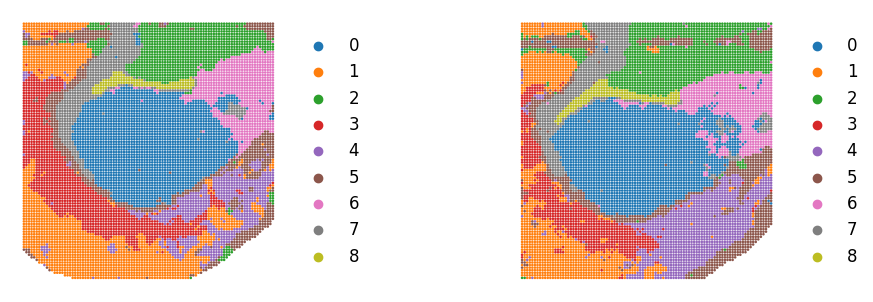

In [6]:
sc.pp.neighbors(adata_concat_rna, use_rep='embedding_omics', random_state=666)
sc.tl.louvain(adata_concat_rna, random_state=666, key_added="louvain", resolution=0.8)
Batch_list = []
section_ids=['H3K27ac_RNA','H3K4me3_RNA']
for section_id in section_ids:
    Batch_list.append(adata_concat_rna[adata_concat_rna.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt

title_size = 12


fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.8, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['louvain'], title=[''],
                       legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=1)

_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['louvain'], title=[''],
                       legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=1)


plt.show()

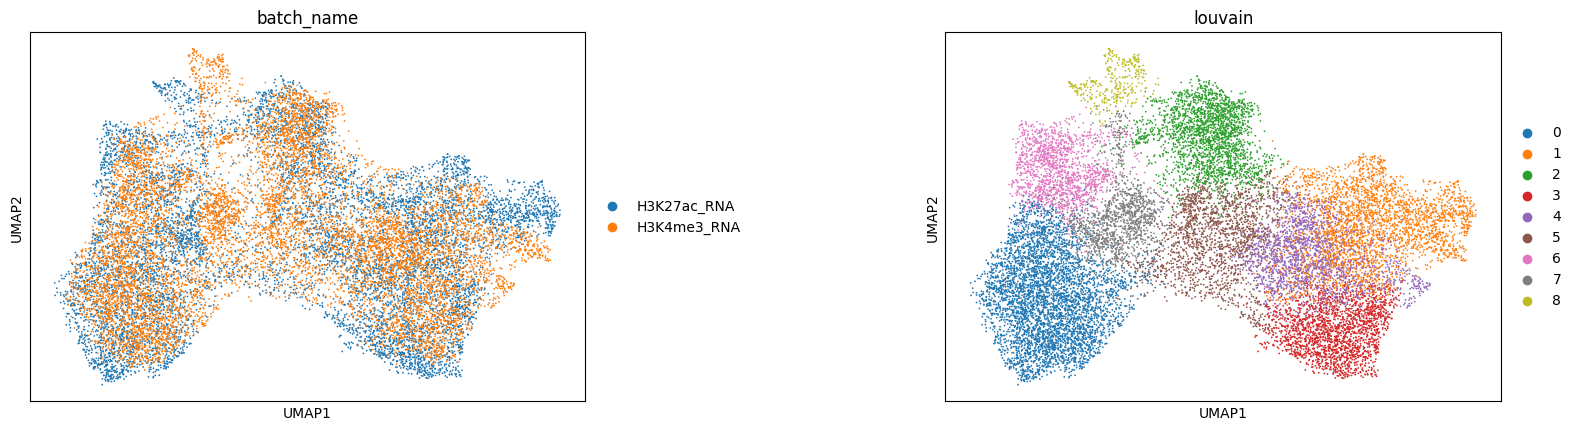

In [7]:
sc.tl.umap(adata_concat_rna, random_state=666)
sc.pl.umap(adata_concat_rna, color=['batch_name','louvain'], wspace=0.5,
           show=True)

In [30]:
adata2=Batch_list[0]
adatam=sc.read('./Data/Dataset7_Mouse_Brain_ATAC/H3K27ac/adata_RNA.h5ad')
sc.pp.normalize_total(adatam, target_sum=1e4)
sc.pp.log1p(adatam)

adatam.obs_names=[x + '_RNA_H3K27ac' for x in adatam.obs_names]
adatam.obs['louvain']=adata2.obs['louvain']

In [36]:
genenew=[
'Pde10a','Bcl11b','Gng7',
'Meis2','Gad2',
'Nr4a2','Epha5',
'Mef2c','Nrgn','Nfix','Camk2n1',
'Syt1', 'Pgm2l1','Adcy1','Meg3',
'Mbp','Mobp','Plp1',
'Ccnd2','Xist','Sox4',
'Zic1','Cacna2d2',
]

In [32]:
sc.pp.scale(adatam)
correct_categories_adatam = ['0', '6', '1', '3', '4', '5', '7', '8','2']
adatam.obs['louvain']=adatam.obs['louvain'].cat.set_categories(correct_categories_adatam)


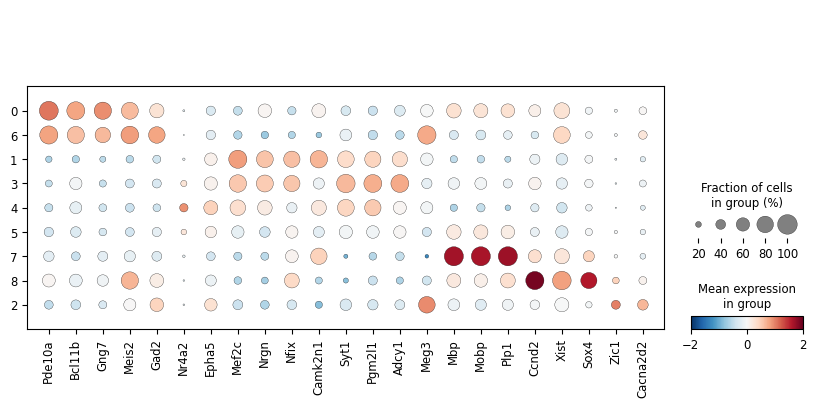

In [37]:
sc.pl.DotPlot(adatam,genenew, groupby='louvain',cmap='RdBu_r',vmin=-2, vmax=2,).show()

## PartII: omics imputation

In [39]:
adata1=Batch_list[0]
adata2=Batch_list[1]

### Mapping

In [47]:
array = np.zeros((adata1.n_obs, adata2.n_vars))
barcode_to_index = {barcode: index for index, barcode in enumerate(adata2.obs.index)}
#intra-domain mapping
for i in range(adata1.n_obs):
    louvain_label = adata1.obs['louvain'][i]
    cells_in_cluster_barcodes = adata2.obs.index[adata2.obs['louvain'] == louvain_label]
    cells_in_cluster = np.array([barcode_to_index[barcode] for barcode in cells_in_cluster_barcodes])
    embeddings_adata1 = adata1.obsm['embedding_omics'][i]
    embeddings_adata2 = adata2.obsm['embedding_omics'][cells_in_cluster]

    distances = np.linalg.norm(embeddings_adata2 - embeddings_adata1, axis=1)
    top_10_indices = np.argsort(distances)[:10]
    top_10_cells = cells_in_cluster[top_10_indices]
    atac_mean = np.mean(adata2[top_10_cells].X, axis=0)
    atac_mean =np.array(atac_mean)
    array_1 = np.squeeze(atac_mean, axis=0)

    array[i]=array_1
#Global mapping
'''
for i in range(adata1.n_obs):
    embeddings_adata1 = adata1.obsm['embedding'][i]
    distances = np.linalg.norm(embeddings_adata2 - embeddings_adata1, axis=1)
    top_10_indices = np.argsort(distances)[:10]
    atac_mean = np.mean(adata2[adata2.obs.index[top_10_indices]].X, axis=0)
    atac_mean =np.array(atac_mean)
    array[i]=atac_mean
'''

In [48]:
array.shape

(9370, 1917)

In [72]:
adata_new=ad.AnnData(X=array)

In [75]:
adata_new.obs_names=adata1.obs_names
adata_new.obs['louvain']=adata1.obs['louvain']
adata_new.var_names=adata2.var_names

In [78]:
adata_new.obsm['spatial']=adata1.obsm['spatial']

### Visualization

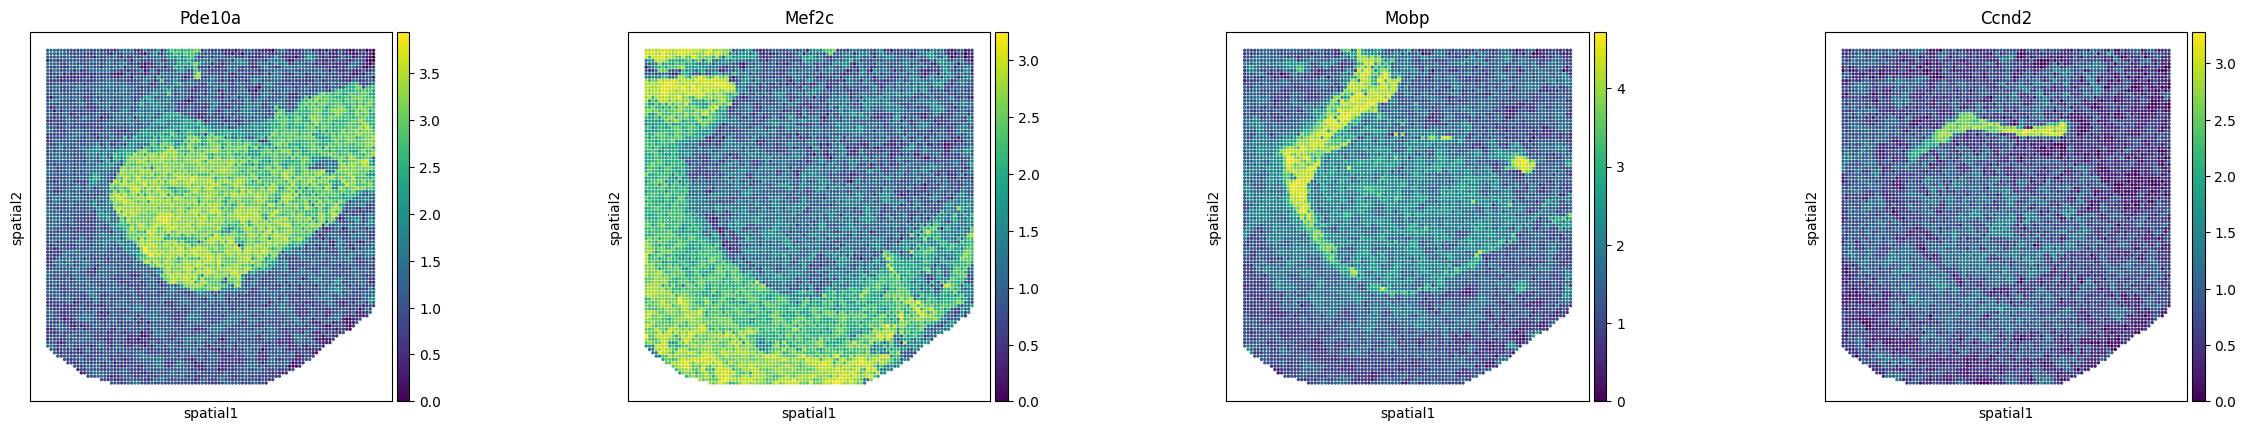

In [79]:
sc.pl.spatial(adata_new,color=['Pde10a','Mef2c', 'Mobp','Ccnd2'],spot_size=1,)

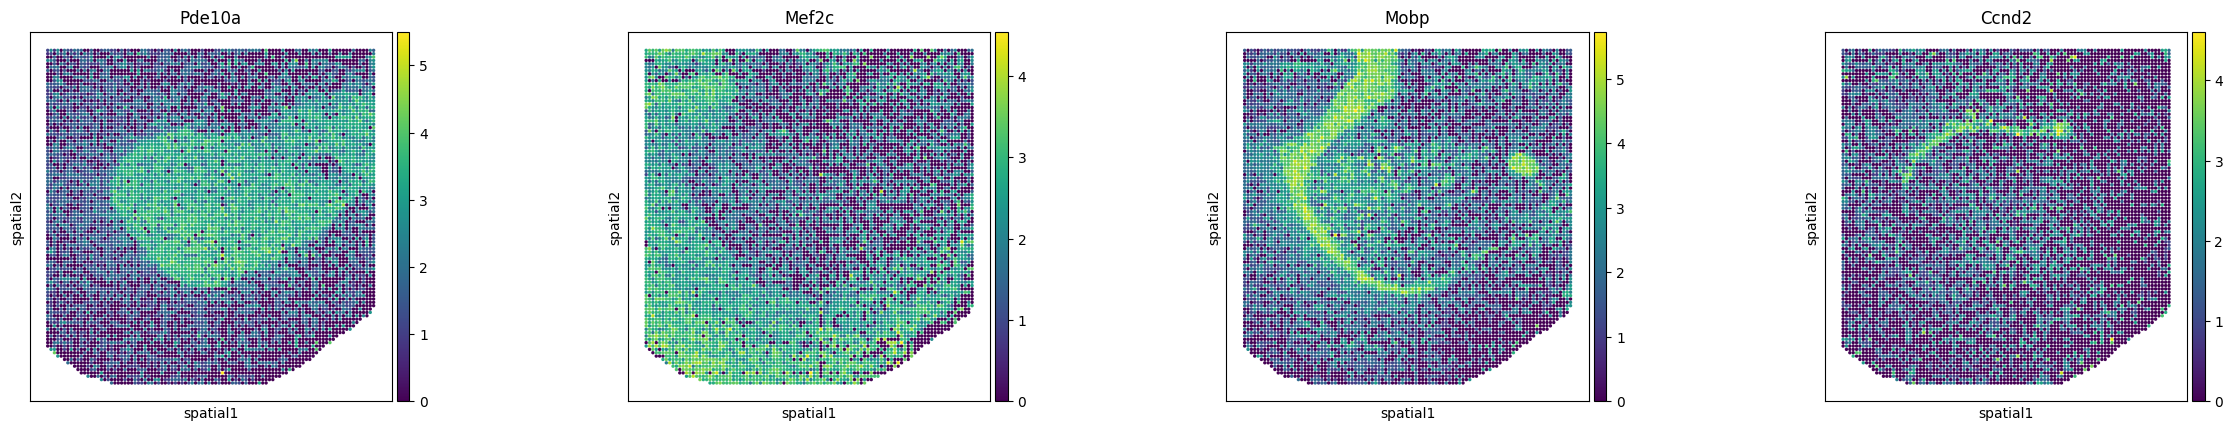

In [80]:
sc.pl.spatial(adata1,color=['Pde10a','Mef2c', 'Mobp','Ccnd2'],spot_size=1,)